In [ ]:
!kaggle datasets download sayedshaun/english-to-bengali-for-machine-translation -p dataset
!unzip /content/dataset/english-to-bengali-for-machine-translation.zip -d dataset

Dataset URL: https://www.kaggle.com/datasets/sayedshaun/english-to-bengali-for-machine-translation
License(s): MIT
  0% 0.00/1.71M [00:00<?, ?B/s]
100% 1.71M/1.71M [00:00<00:00, 153MB/s]
Archive:  /content/dataset/english-to-bengali-for-machine-translation.zip
  inflating: dataset/english_to_bangla.csv  


In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/tf')

Mounted at /content/drive


In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transfomer import Transformer
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.optim.lr_scheduler import ReduceLROnPlateau
import re

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_SEQ_LENGTH = 50
BATCH_SIZE = 32
D_MODEL = 512
NUM_HEADS = 8
NUM_LAYERS = 6
NUM_EPOCHS = 25
LEARNING_RATE = 0.0001

In [ ]:
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    if 'en' not in df.columns or 'bn' not in df.columns:
        raise ValueError("DataFrame must have 'en' and 'bn' columns")
    return df
def clean_text(text):
    # Basic cleaning
    text = re.sub(r'[^\w\s\u0980-\u09FF]', '', str(text))
    text = text.lower().strip()
    return text

In [ ]:
class Tokenizer:
    def __init__(self, texts, max_vocab_size=None):
        self.word_index = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.index_word = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.build_vocab(texts, max_vocab_size)
    def build_vocab(self, texts, max_vocab_size):
        word_counts = Counter()
        for text in texts:
            for word in text.split():
                word_counts[word] += 1
        vocab_size = len(self.word_index)
        for word, _ in word_counts.most_common(max_vocab_size):
            if word not in self.word_index:
                self.word_index[word] = vocab_size
                self.index_word[vocab_size] = word
                vocab_size += 1

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = []
            sequence.append(self.word_index["<sos>"])
            for word in text.split():
                if word in self.word_index:
                    sequence.append(self.word_index[word])
                else:
                    sequence.append(self.word_index["<unk>"])
            sequence.append(self.word_index["<eos>"])
            sequences.append(sequence)
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for idx in sequence:
                if idx in self.index_word and idx not in [0, 1, 2]:
                    text.append(self.index_word[idx])
            texts.append(" ".join(text))
        return texts
    def size(self):
        return len(self.word_index)
def pad_sequences(sequences, maxlen, padding_value=0):
    padded_sequences = []
    for sequence in sequences:
        if len(sequence) > maxlen:
            padded_sequences.append(sequence[:maxlen])
        else:
            padded_sequences.append(sequence + [padding_value] * (maxlen - len(sequence)))
    return torch.LongTensor(padded_sequences)

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, src_seqs, tgt_seqs):
        self.src_seqs = src_seqs
        self.tgt_seqs = tgt_seqs

    def __len__(self):
        return len(self.src_seqs)

    def __getitem__(self, idx):
        return self.src_seqs[idx], self.tgt_seqs[idx]

In [ ]:
def train_model():
    print("Loading dataset...")
    df = load_data('/content/dataset/english_to_bangla.csv')
    df['en_cleaned'] = df['en'].apply(clean_text)
    df['bn_cleaned'] = df['bn'].apply(clean_text)
    df = df[(df['en_cleaned'].str.len() > 0) &
            (df['bn_cleaned'].str.len() > 0) &
            (df['en_cleaned'].str.len() < 1000) &
            (df['bn_cleaned'].str.len() < 1000)]
    train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
    print("Building tokenizers...")
    en_tokenizer = Tokenizer(train_df['en_cleaned'], max_vocab_size=10000)
    bn_tokenizer = Tokenizer(train_df['bn_cleaned'], max_vocab_size=10000)

    # Convert text to sequences
    train_en_seqs = en_tokenizer.texts_to_sequences(train_df['en_cleaned'])
    train_bn_seqs = bn_tokenizer.texts_to_sequences(train_df['bn_cleaned'])
    test_en_seqs = en_tokenizer.texts_to_sequences(test_df['en_cleaned'])
    test_bn_seqs = bn_tokenizer.texts_to_sequences(test_df['bn_cleaned'])

    # Pad sequences
    train_en_padded = pad_sequences(train_en_seqs, MAX_SEQ_LENGTH)
    train_bn_padded = pad_sequences(train_bn_seqs, MAX_SEQ_LENGTH)
    test_en_padded = pad_sequences(test_en_seqs, MAX_SEQ_LENGTH)
    test_bn_padded = pad_sequences(test_bn_seqs, MAX_SEQ_LENGTH)

    # Create datasets and dataloaders
    train_dataset = TranslationDataset(train_en_padded, train_bn_padded)
    test_dataset = TranslationDataset(test_en_padded, test_bn_padded)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Initialize the model
    print("Initializing model...")
    model = Transformer(
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        encoder_vocab_size=en_tokenizer.size(),
        decoder_vocab_size=bn_tokenizer.size(),
        num_layers=NUM_LAYERS,
        pad_idx=0
    ).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
    scheduler=ReduceLROnPlateau(optimizer,'min',factor=0.5,patience=1)
    train_loss_history = []
    val_loss_history = []
    # Training loop
    print("Starting training...")
    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        for batch_idx, (src, tgt) in enumerate(train_loader):
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            optimizer.zero_grad()
            output = model(src, tgt_input)
            output = output.reshape(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = criterion(output, tgt_output)
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(train_loader):
                print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
        avg_loss = total_loss / len(train_loader)
        train_loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} completed, Average Loss: {avg_loss:.4f}")
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for src, tgt in test_loader:
                src, tgt = src.to(device), tgt.to(device)
                tgt_input = tgt[:, :-1]
                tgt_output = tgt[:, 1:]

                output = model(src, tgt_input)
                output = output.reshape(-1, output.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = criterion(output, tgt_output)
                val_loss += loss.item()

            avg_val_loss = val_loss / len(test_loader)
            val_loss_history.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
        scheduler.step(avg_val_loss)

    # Save the trained model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'en_tokenizer': en_tokenizer,
        'bn_tokenizer': bn_tokenizer,
    }, 'translation_transformer.pth')

    print("Model saved successfully!")
    return train_loss_history,val_loss_history,model, en_tokenizer, bn_tokenizer

In [ ]:
def translate_text(model, text, en_tokenizer, bn_tokenizer, max_length=50):
    model.eval()
    cleaned_text = clean_text(text)
    input_seq = en_tokenizer.texts_to_sequences([cleaned_text])
    padded_input = pad_sequences(input_seq, max_length)
    src = padded_input.to(device)

    # Start with <sos> token
    tgt = torch.LongTensor([[bn_tokenizer.word_index["<sos>"]]]).to(device)

    with torch.no_grad():
        for i in range(max_length-1):
            output = model(src, tgt)
            next_token = output[:, -1].argmax(-1).unsqueeze(1)
            tgt = torch.cat([tgt, next_token], dim=1)
            if next_token.item() == bn_tokenizer.word_index["<eos>"]:
                break
    output_seq = tgt.squeeze().cpu().numpy().tolist()
    translated_text = bn_tokenizer.sequences_to_texts([output_seq])[0]
    return translated_text

In [ ]:
train_loss_history,val_loss_history,model, en_tokenizer, bn_tokenizer = train_model()

Loading dataset...
Building tokenizers...
Initializing model...
Starting training...
Epoch 1/25, Batch 100/1099, Loss: 5.8423
Epoch 1/25, Batch 200/1099, Loss: 5.1775
Epoch 1/25, Batch 300/1099, Loss: 4.8411
Epoch 1/25, Batch 400/1099, Loss: 4.4616
Epoch 1/25, Batch 500/1099, Loss: 4.4454
Epoch 1/25, Batch 600/1099, Loss: 4.0537
Epoch 1/25, Batch 700/1099, Loss: 4.3035
Epoch 1/25, Batch 800/1099, Loss: 4.1001
Epoch 1/25, Batch 900/1099, Loss: 4.1744
Epoch 1/25, Batch 1000/1099, Loss: 4.0112
Epoch 1/25, Batch 1099/1099, Loss: 4.3105
Epoch 1/25 completed, Average Loss: 4.6875
Validation Loss: 3.6890
Epoch 2/25, Batch 100/1099, Loss: 3.6682
Epoch 2/25, Batch 200/1099, Loss: 3.6227
Epoch 2/25, Batch 300/1099, Loss: 3.5504
Epoch 2/25, Batch 400/1099, Loss: 3.2407
Epoch 2/25, Batch 500/1099, Loss: 3.3004
Epoch 2/25, Batch 600/1099, Loss: 3.6306
Epoch 2/25, Batch 700/1099, Loss: 3.4487
Epoch 2/25, Batch 800/1099, Loss: 3.5294
Epoch 2/25, Batch 900/1099, Loss: 3.4487
Epoch 2/25, Batch 1000/109

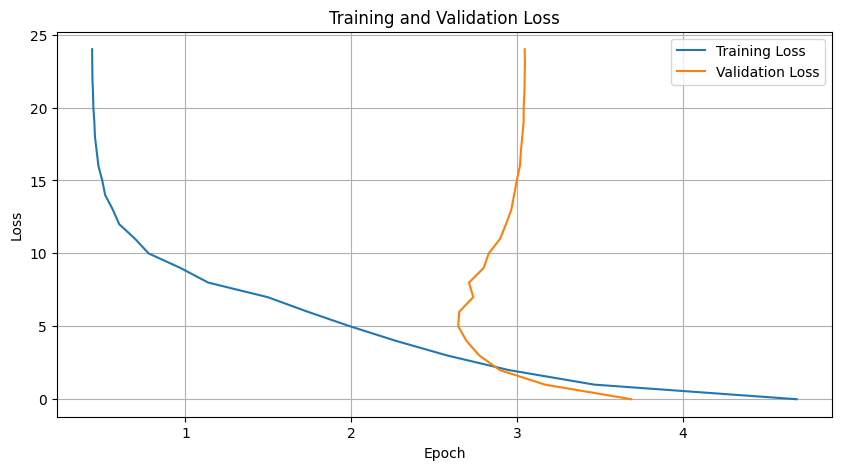

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history,[epoch for epoch in range(NUM_EPOCHS)], label='Training Loss')
plt.plot(val_loss_history,[epoch for epoch in range(NUM_EPOCHS)], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
example = "I love you"
translation = translate_text(model, example, en_tokenizer, bn_tokenizer)
print(f"\nTranslation example:")
print(f"English: {example}")
print(f"Bengali: {translation}")


Translation example:
English: I love you
Bengali: আমি তোমাকে ভালোবাসি


In [ ]:
def load_pretrained_model(model_path):
    checkpoint = torch.load(model_path)
    en_tokenizer = checkpoint['en_tokenizer']
    bn_tokenizer = checkpoint['bn_tokenizer']

    model = Transformer(
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        encoder_vocab_size=en_tokenizer.size(),
        decoder_vocab_size=bn_tokenizer.size(),
        num_layers=NUM_LAYERS,
        pad_idx=0
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, en_tokenizer, bn_tokenizer


In [ ]:
from google.colab import files
files.download('translation_transformer.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os

file_path = "/content/translation_transformer.pth"  # Replace with your file path
file_size = os.path.getsize(file_path)

print(f"Size of the file: {file_size} bytes")


Size of the file: 725553960 bytes
